In [1]:
import mne
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

peopleNumbers = list(range(1, 22))
musicTypes = ["classicalMusic", "genMusic01", "genMusic02", "genMusic03", "washout"]

In [2]:
def getWindow(personNumber, musicType):
    numStr = str(personNumber)
    if personNumber < 10: numStr = "0" + numStr
    file_path = rf"daly_2019\sub-{numStr}\eeg\sub-{numStr}_task-{musicType}_events.json"

    with open(file_path, 'r') as f:
        event_data = json.load(f)

    # Now search for the Trial start event
    start = None

    for event_code, event_info in event_data.items():
        if event_info.get("LongName", "").lower() == "trial start":
            start = int(event_code)  # Convert the event code (string) to int
            break

    if start is None: assert False

    # assuming only generated music

    start //= 5000
    end = start + 40
    return start, end

getWindow(1, musicTypes[1])

(0, 40)

In [3]:
def find_nonzero_intervals_with_values(signal, times):
    # Find where signal is nonzero
    nonzero = signal != 0
    
    # Find edges: start (False→True), end (True→False)
    edges = np.diff(nonzero.astype(int))
    start_idxs = np.where(edges == 1)[0] + 1  # shift by 1
    end_idxs = np.where(edges == -1)[0] + 1
    
    # Edge cases
    if nonzero[0]:
        start_idxs = np.insert(start_idxs, 0, 0)
    if nonzero[-1]:
        end_idxs = np.append(end_idxs, len(signal))
    
    intervals = []
    for start, end in zip(start_idxs, end_idxs):
        interval_times = times[start:end]
        interval_signal = signal[start:end]
        intervals.append((interval_times, interval_signal))
    
    return intervals

def get_music_from_eeg(personNumber, musicType):

    numStr = str(personNumber)
    if personNumber < 10:
        numStr = "0" + numStr

    edf_path = rf"daly_2019/sub-{numStr}/eeg/sub-{numStr}_task-{musicType}_eeg.edf"
    
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    sig, times = raw.get_data(picks='music', return_times=True)
    sig = sig.flatten()
    music = np.round(sig*20*1e6).astype(int)

    intervals = find_nonzero_intervals_with_values(music, times)
    results = {
        "session": [],
        "music": [],
        "start_time": [],
        "end_time": []
    }
    for idx, (interval_times, interval_signal) in enumerate(intervals):
        results['session'].append(idx+1)
        results['music'].append(int(np.unique(interval_signal)[0]))
        results['start_time'].append(float(interval_times[0]))
        results['end_time'].append(float(interval_times[-1]))

    return results

personNumber = 8
musicType = musicTypes[1]
results = get_music_from_eeg(personNumber, musicType)
print(results)


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-08\eeg\sub-08_task-genMusic01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 595999  =      0.000 ...   595.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\628987842.py:32: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(edf_path, preload=True)


{'session': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'music': [452, 752, 753, 453, 281, 823, 821, 822, 281, 821, 752], 'start_time': [50.0, 95.0, 141.0, 187.0, 231.0, 277.0, 323.0, 369.0, 413.0, 460.0, 549.0], 'end_time': [50.999, 95.999, 141.999, 187.999, 231.999, 277.999, 323.999, 369.999, 413.999, 460.999, 549.999]}


In [4]:
def collapse(data, times, personNumber, musicType):
    """
    Select and collapse EEG data based on specified time intervals,
    and create a transformed consecutive time axis.

    Args:
        data (ndarray): EEG data of shape (n_channels, n_times).
        times (ndarray): Time vector of shape (n_times,).
        session_info (dict): Dictionary with 'start_time' and 'end_time' lists.

    Returns:
        collapsed_data (ndarray): Selected EEG data (n_channels, selected_times).
        collapsed_times (ndarray): Original selected times.
        transformed_times (ndarray): New consecutive times starting from 0.
    """
    session_info = get_music_from_eeg(personNumber, musicType)
    
    selected_data = []
    selected_times = []

    start_times = session_info['start_time']
    end_times = session_info['end_time']

    for start, end in zip(start_times, end_times):
        mask = (times >= start) & (times <= end)
        selected_data.append(data[:, mask])
        selected_times.append(times[mask])

    collapsed_data = np.concatenate(selected_data, axis=1)
    collapsed_times = np.concatenate(selected_times, axis=0)

    # Create transformed times
    n_points = collapsed_times.shape[0]
    transformed_times = np.arange(n_points)

    return collapsed_data, collapsed_times, transformed_times


In [ ]:
# Function to save collapsed matrix to CSV
def saveCollapsedMatrixToCSV(personNumber, musicType, filename, filtered=True):
    combined_array = getCollapsedMatrix(personNumber, musicType, filtered)

    # Load raw again to get channel names
    numStr = str(personNumber)
    if personNumber < 10:
        numStr = "0" + numStr
    file_path = rf"daly_2019\sub-{numStr}\eeg\sub-{numStr}_task-{musicType}_eeg.edf"
    raw = mne.io.read_raw_edf(file_path, preload=True)

    channel_names = raw.ch_names

    # Create DataFrame
    df = pd.DataFrame(combined_array, columns=["Transformed Time"] + channel_names)

    # Save to CSV
    df.to_csv(filename, index=False)

# Uncomment the lines below to run the tests
# test_getCollapsedMatrix()
# saveCollapsedMatrixToCSV(18, 'classicalMusic', 'collapsed_data.csv')


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-18\eeg\sub-18_task-classicalMusic_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1899999  =      0.000 ...  1899.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\2603976237.py:6: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(file_path, preload=True)



Minimum and Maximum values:
ft_valance -> min: 0.0 , max: 7.839849999999999e-06
ft_arousal -> min: 0.0 , max: 4.67091e-06


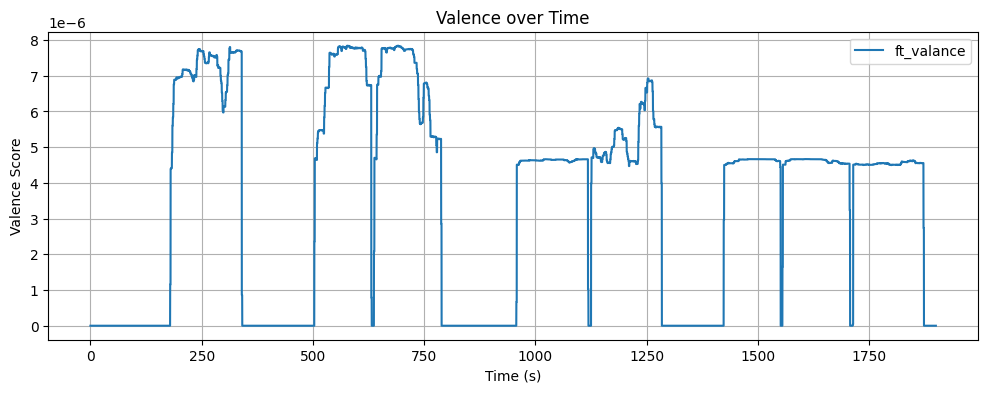

C:\Users\manis\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


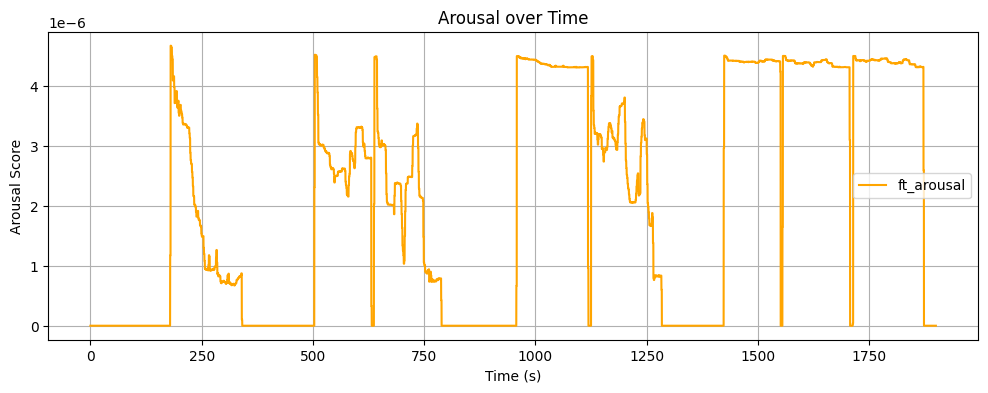

In [14]:
file_path = r"C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-18\eeg\sub-18_task-classicalMusic_eeg.edf"

pd.set_option('display.max_rows', None)

# Load raw EEG
raw = mne.io.read_raw_edf(file_path, preload=True)

# Create DataFrame
data, times = raw.get_data(return_times=True)
df = pd.DataFrame(data.T, columns=raw.ch_names)
df['time (s)'] = times
df = df[['time (s)'] + raw.ch_names]

# Select only ft_valance and ft_arousal columns
features_df = df[['time (s)', 'ft_valance', 'ft_arousal']]

# Print every 1000th row from valence and arousal
# print(features_df.iloc[::1000])

# Print min and max for valence and arousal
print("\nMinimum and Maximum values:")
print("ft_valance -> min:", features_df['ft_valance'].min(), ", max:", features_df['ft_valance'].max())
print("ft_arousal -> min:", features_df['ft_arousal'].min(), ", max:", features_df['ft_arousal'].max())

# Plot ft_valance over time
plt.figure(figsize=(12, 4))
plt.plot(features_df['time (s)'], features_df['ft_valance'], label='ft_valance')
plt.title('Valence over Time')
plt.xlabel('Time (s)')
plt.ylabel('Valence Score')
plt.grid()
plt.legend()
plt.show()

# Plot ft_arousal over time
plt.figure(figsize=(12, 4))
plt.plot(features_df['time (s)'], features_df['ft_arousal'], label='ft_arousal', color='orange')
plt.title('Arousal over Time')
plt.xlabel('Time (s)')
plt.ylabel('Arousal Score')
plt.grid()
plt.legend()
plt.show()


In [17]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualisePerson(personNumber, musicType, filtered=True):
    numStr = str(personNumber)
    if personNumber < 10:
        numStr = "0" + numStr

    file_path = rf"daly_2019\sub-{numStr}\eeg\sub-{numStr}_task-{musicType}_eeg.edf"

    # Load raw EDF file
    raw = mne.io.read_raw_edf(file_path, preload=True)

    print("All channel names:", raw.ch_names)

    if filtered:
        # Only filter EEG channels
        channel_types = raw.get_channel_types()
        eeg_indices = [i for i, ch_type in enumerate(channel_types) if ch_type == 'eeg']
        raw.filter(l_freq=1., h_freq=45., picks=eeg_indices)

    # Plot all channels (including ft_valence and ft_arousal)
    raw.plot(n_channels=20, scalings='auto', title='Raw EEG Data', picks='all')

    # Load full EEG data
    data, times = raw.get_data(return_times=True)

    # Load valence and arousal separately
    valence_data, _ = raw.get_data(picks='ft_valance', return_times=True)
    arousal_data, _ = raw.get_data(picks='ft_arousal', return_times=True)

    # Collapse EEG data
    collapsed_data, collapsed_times, transformed_times = collapse(data, times, personNumber, musicType)

    # Collapse valence and arousal separately
    collapsed_valence, _, _ = collapse(data, times, personNumber, musicType)
    collapsed_arousal, _, _ = collapse(data, times, personNumber, musicType)

    print(f"Original EEG data shape: {data.shape}")
    print(f"Collapsed EEG data shape: {collapsed_data.shape}")
    print(f"Original valence shape: {valence_data.shape}")
    print(f"Collapsed valence shape: {collapsed_valence.shape}")
    print(f"Original arousal shape: {arousal_data.shape}")
    print(f"Collapsed arousal shape: {collapsed_arousal.shape}")

    # Define channel index for EEG (e.g., Fp1)
    channel_index = 0

    # ---------------- Before collapse ----------------

    # 1. EEG (before collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(times, data[channel_index])
    plt.title(f"Original EEG signal from channel {raw.ch_names[channel_index]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid()
    plt.show()

    # 2. Valence (before collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(times, valence_data[0])
    plt.title("Original ft_valance feature")
    plt.xlabel("Time (s)")
    plt.ylabel("Valence Score")
    plt.grid()
    plt.show()

    # 3. Arousal (before collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(times, arousal_data[0])
    plt.title("Original ft_arousal feature")
    plt.xlabel("Time (s)")
    plt.ylabel("Arousal Score")
    plt.grid()
    plt.show()

    # ---------------- After collapse ----------------

    # 4. EEG (after collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(transformed_times, collapsed_data[channel_index])
    plt.title(f"Collapsed EEG signal from channel {raw.ch_names[channel_index]} (transformed time)")
    plt.xlabel("Transformed Time (sample index)")
    plt.ylabel("Amplitude (µV)")
    plt.grid()
    plt.show()

    # 5. Valence (after collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(transformed_times, collapsed_valence[0])
    plt.title("Collapsed ft_valance feature (transformed time)")
    plt.xlabel("Transformed Time (sample index)")
    plt.ylabel("Valence Score")
    plt.grid()
    plt.show()

    # 6. Arousal (after collapse)
    plt.figure(figsize=(12, 4))
    plt.plot(transformed_times, collapsed_arousal[0])
    plt.title("Collapsed ft_arousal feature (transformed time)")
    plt.xlabel("Transformed Time (sample index)")
    plt.ylabel("Arousal Score")
    plt.grid()
    plt.show()


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-06\eeg\sub-06_task-genMusic02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 592999  =      0.000 ...   592.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\3683302166.py:14: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(file_path, preload=True)


All channel names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'ft_valance', 'ft_arousal', 'ft_x', 'ft_y', 'ft_ghostvalence', 'ft_ghostarousal', 'music', 'trialtype', 'sams_valence', 'sams_arousal', 'sams_valencert', 'sams_arousalrt', 'nback_stimuli', 'nback_keypress', 'Status']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (3.30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


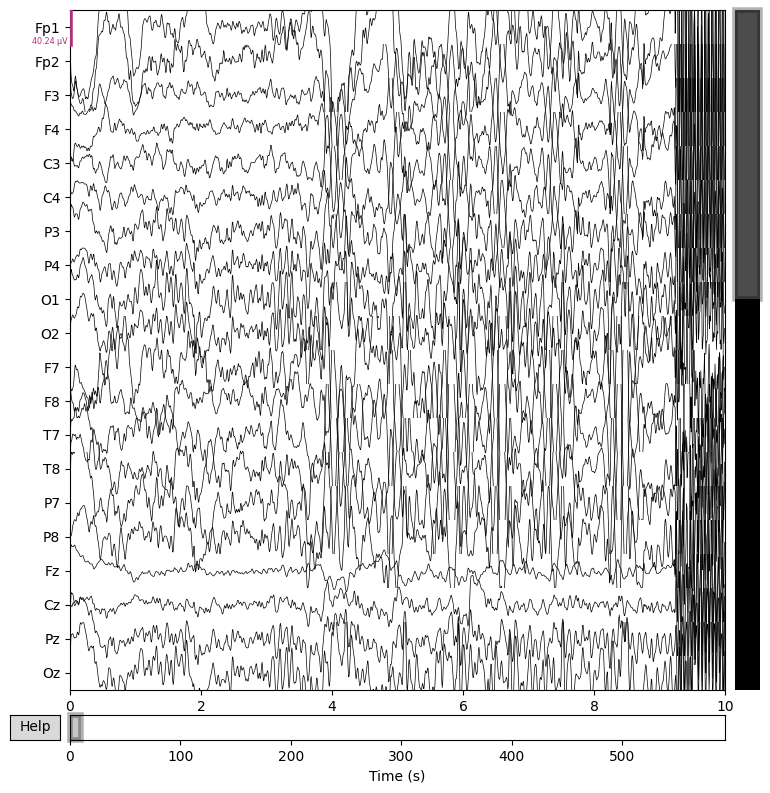

Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-06\eeg\sub-06_task-genMusic02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 592999  =      0.000 ...   592.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\628987842.py:32: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-06\eeg\sub-06_task-genMusic02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 592999  =      0.000 ...   592.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\628987842.py:32: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-06\eeg\sub-06_task-genMusic02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 592999  =      0.000 ...   592.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\628987842.py:32: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Original EEG data shape: (47, 593000)
Collapsed EEG data shape: (47, 8000)
Original valence shape: (1, 593000)
Collapsed valence shape: (47, 8000)
Original arousal shape: (1, 593000)
Collapsed arousal shape: (47, 8000)


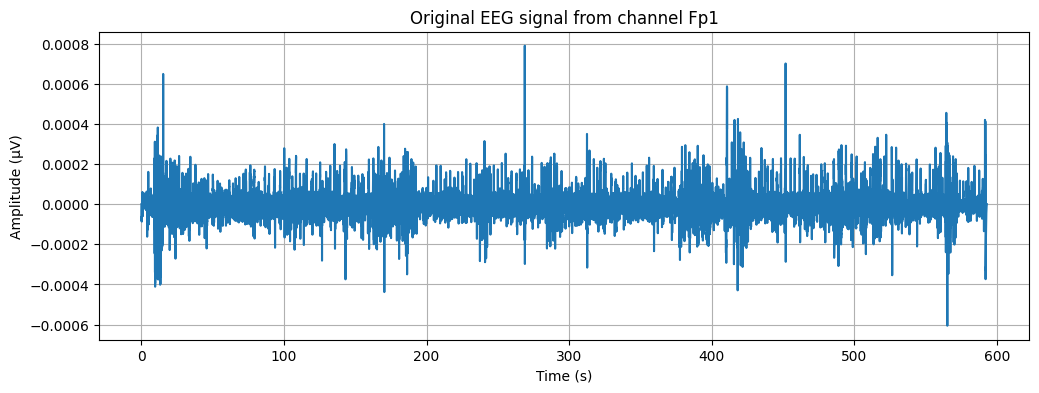

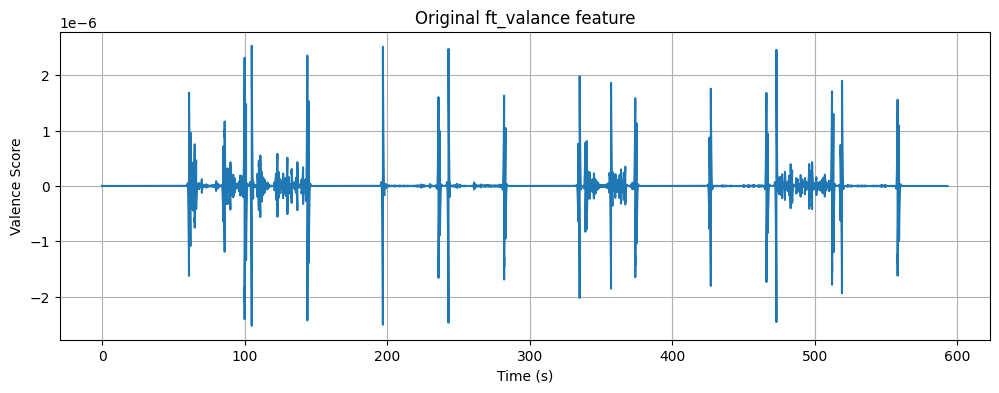

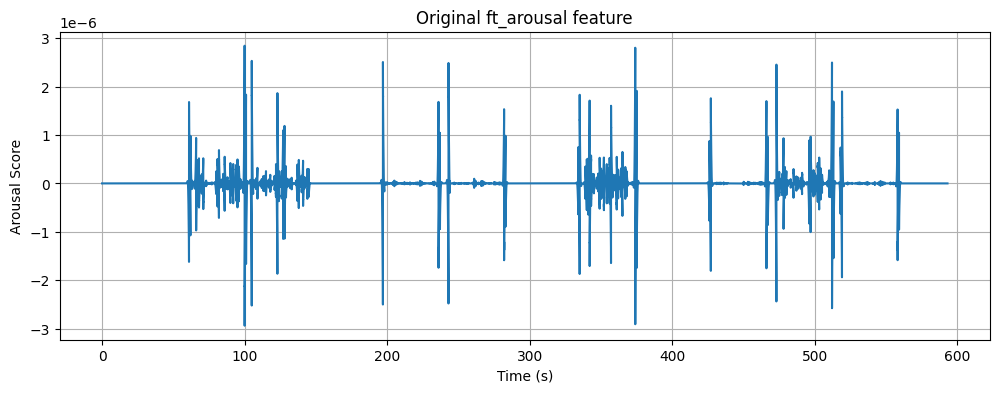

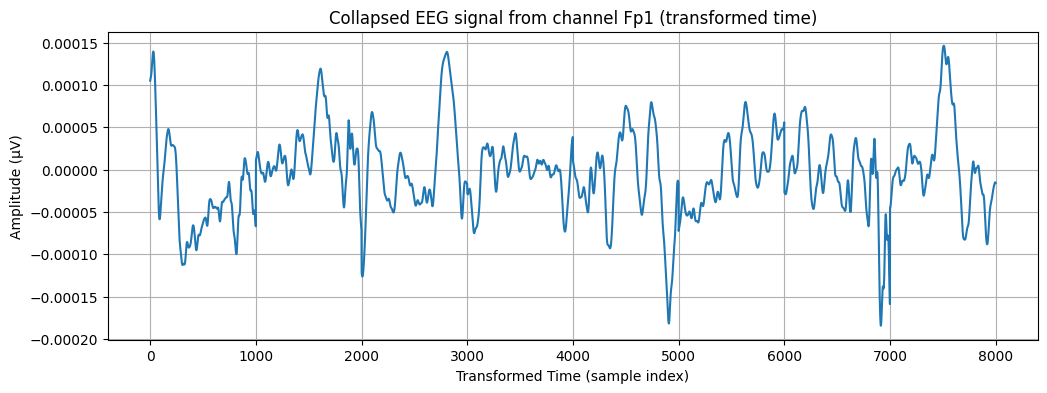

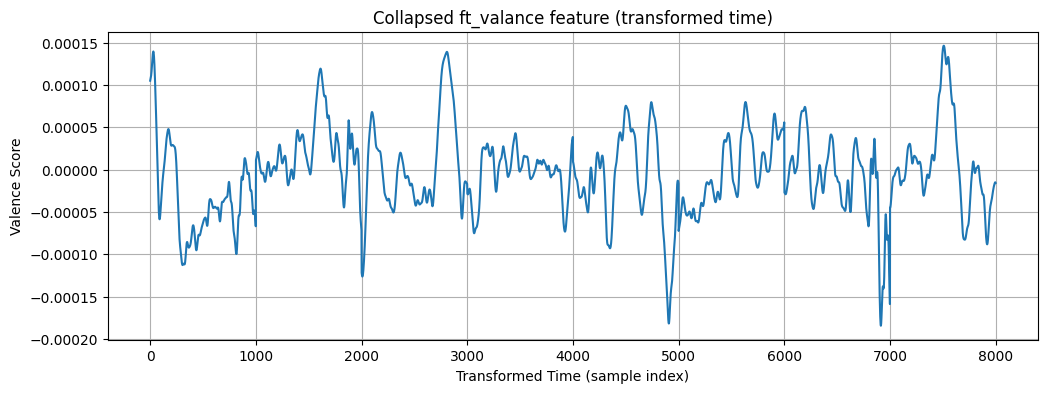

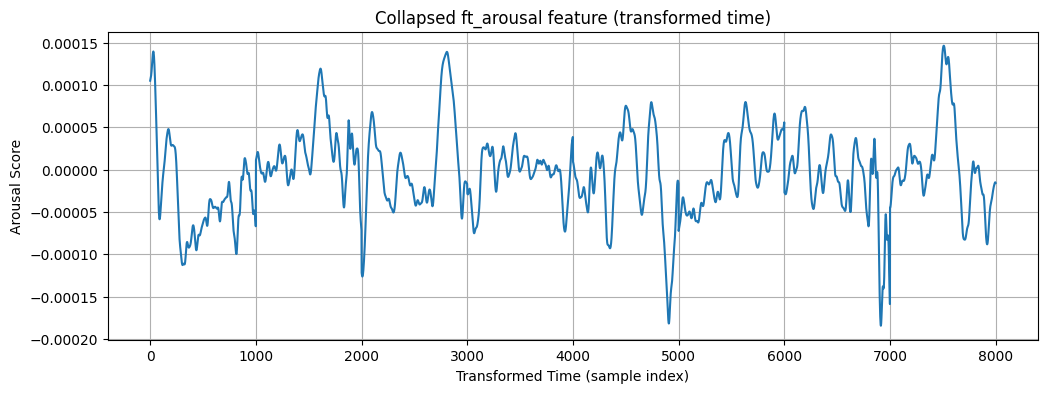

In [19]:
visualisePerson(6, musicTypes[2], True)

In [29]:
def getCollapsedMatrix(personNumber, musicType, filtered=True):
    numStr = str(personNumber)
    if personNumber < 10:
        numStr = "0" + numStr

    file_path = rf"daly_2019\sub-{numStr}\eeg\sub-{numStr}_task-{musicType}_eeg.edf"

    # Load raw EDF file
    raw = mne.io.read_raw_edf(file_path, preload=True)

    if filtered:
        # Only filter EEG channels
        channel_types = raw.get_channel_types()
        eeg_indices = [i for i, ch_type in enumerate(channel_types) if ch_type == 'eeg']
        raw.filter(l_freq=1., h_freq=45., picks=eeg_indices)

    # Load full EEG data
    data, times = raw.get_data(return_times=True)

    # Collapse all channels together
    collapsed_data, collapsed_times, transformed_times = collapse(data, times, personNumber, musicType)

    # Stack collapsed data and transformed times together as an ndarray
    combined_array = np.vstack((transformed_times, collapsed_data)).T

    return combined_array

Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-18\eeg\sub-18_task-classicalMusic_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1899999  =      0.000 ...  1899.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\796995580.py:9: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(file_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Extracting EDF parameters from C:\Users\manis\OneDrive\_Laksh\CamMINDHackathon\daly_2019\sub-18\eeg\sub-18_task-classicalMusic_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1899999  =      0.000 ...  1899.999 secs...


C:\Users\manis\AppData\Local\Temp\ipykernel_3900\628987842.py:32: RuntimeWarning: Physical range is not defined in following channels:
sams_valence, sams_arousal, sams_valencert, sams_arousalrt, nback_stimuli, nback_keypress
  raw = mne.io.read_raw_edf(edf_path, preload=True)


<Figure size 1200x400 with 0 Axes>

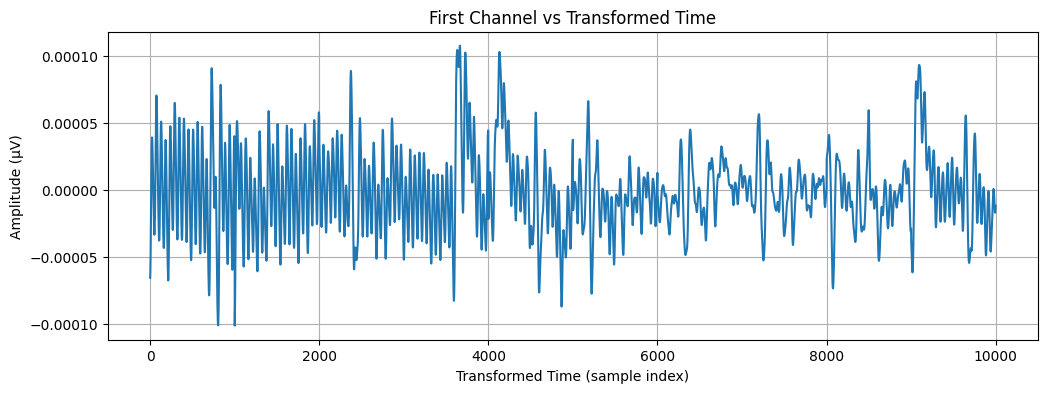

In [30]:
def test_getCollapsedMatrix():
    personNumber = 18
    musicType = 'classicalMusic'

    combined_array = getCollapsedMatrix(personNumber, musicType)

    # Plot first channel vs transformed time
    plt.figure(figsize=(12, 4))
    plt.plot(combined_array[:, 0], combined_array[:, 1])
    plt.title("First Channel vs Transformed Time")
    plt.xlabel("Transformed Time (sample index)")
    plt.ylabel("Amplitude (µV)")
    plt.grid()
    plt.show()

# Uncomment the line below to run the test
test_getCollapsedMatrix()
